# Analiza tvitov ruskih trolov

## Člani skupine
* Žan Bizjak
* Gašper Mrak
* Matej Fajdiga
* Uroš Koritnik
* Jakob Kovačič

## Opis problema
Za projekt pri predmetu smo si izbrali podatkovno analizo tvitov ruskih "trolov", s katerimi naj bi Rusija vplivala na Ameriške volitve. Analizirali bomo vsebine tvitov, lastnosti računov in preko tega poskusili ugotoviti razne vzorce v objavah - najpogostejše fraze, prevladujoče "heštege", ciljne skupine, časovne intervale ipd. Hkrati bi tudi lahko vpeljali tvite in račune dejanskih uporabnikov, primerjali rezultate in tako morda ugotovili ključne razlike med njima.

## Podatki
[Začetne podatke](https://www.kaggle.com/vikasg/russian-troll-tweets), ki vsebujejo 200.000 tvitov, smo pridobili s Kaggla, in sicer dve CSV datoteki: "tweets" in "users". Prva vsebuje podatke o tvitih, druga pa o uporabnikih. Relacijsko se povezujeta prek atributa "user_id".

Med raziskavo smo naleteli na [še večji nabor podatkov](https://github.com/fivethirtyeight/russian-troll-tweets), ki vsebuje 3 milijone tvitov ruskih trolov. Te bomo po končani analizi manjšega nabora uporabili za primerjavo rezultatov.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import ast
import warnings
import math
import seaborn as sb
import networkx as nx
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [2]:
tweets_data = pd.read_csv("podatki/tweets.csv", dtype={'user_id': 'object', 'tweet_id': 'object'}, parse_dates=['created_str'])
users_data = pd.read_csv("podatki/users.csv", dtype={'id': 'object'}, parse_dates=['created_at'])
tweets_data = tweets_data.dropna(subset=['text']) # Odstrani tvite s praznim tekstom
tweets_data = tweets_data.drop(['retweeted', 'posted', 'created_at'], axis=1) # Odstrani nepotrebne stolpce

## Retweeti

Popravimo stolpec *'retweeted'*...

In [5]:
tweets_data['retweeted'] = tweets_data['text'].str.contains('RT @')
round(tweets_data['retweeted'].mean()*100,1)

72.6

... in opazimo, da je kar 72,6% odstotka tweetov retweetov - torej je večina trollov le delila objave ostalih.

## Časovna porazdelitev tweetov

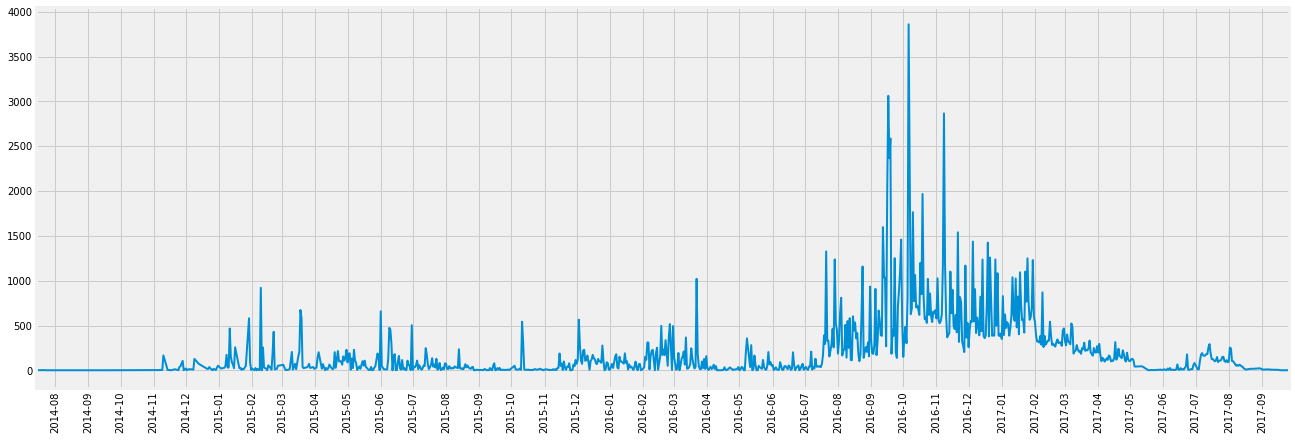

In [55]:
import matplotlib.dates as mdates
plot = tweets_data['created_str'].dt.date.value_counts().plot(linewidth=2, figsize=(20,7))
plot.xaxis.set_major_locator(mdates.MonthLocator())
plot.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plot = plt.xticks(rotation='vertical')

Če prikažemo število tweetov glede na čas, lahko razberemo tri obdobja povečanega tweetanja. Z uporabo Wikipedijinega portala Current Events smo poskušali povezati vrhove s svetovnimi dogodki.

- Prvo obdobje sovpada z ameriškimi sankcijami na Severno Korejo ter s terorističnim napadom na francoski satirični tednik Charlie Hebdo.

- Drugo obdobje ne sovpada s svetovnimi dogodki, ampak zdi se, da število tweetov narašča z naraščajočo priljubljenostjo Donalda Trumpa in njegovo kandidaturo.

- Tretje obdobje sovpada z začetkom partijskih volitev v ZDA, podobno kakor v prejšnjem grafu. Dogodka odgovorna za vrhova sta predsedniška debata med Donaldom Trumpom in Hillary Clinton, ter škandal slednje glede njenega upravljanja zaupnih dokumentov medtem, ko je bila zaposlena v Beli Hiši.

## Časovna porazdelitev uporabniških računov

Text(0,0.5,'count')

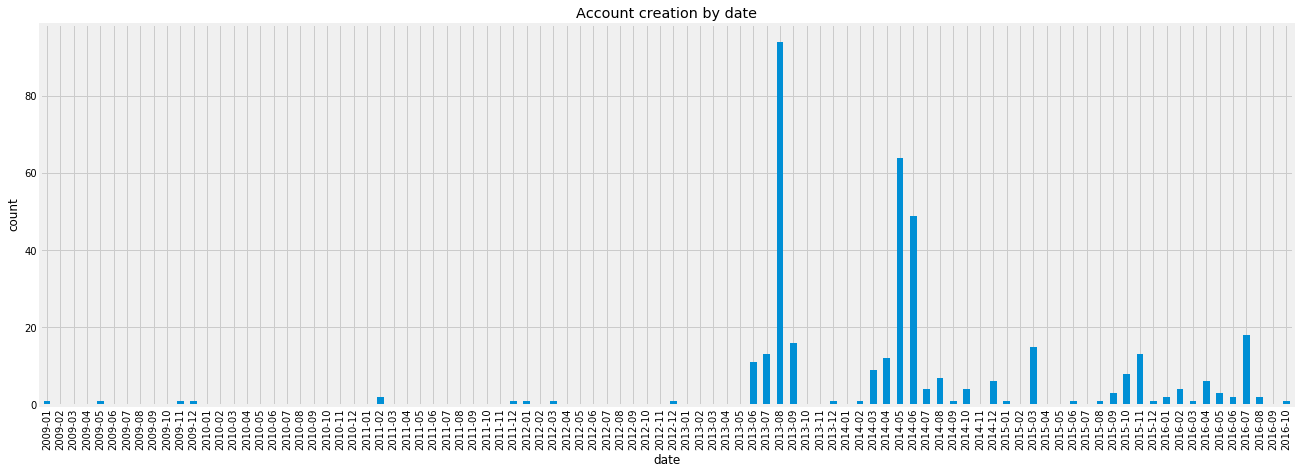

In [3]:
users_data['month'] = users_data['created_at'].dropna().dt.to_period('M')
months = users_data['month'].dropna().sort_values()
index = pd.PeriodIndex(start=months.iloc[0], end=months.iloc[-1])
users_data.groupby('month')['created_at'].count().reindex(index).plot.bar(figsize=(20,7), linewidth=1)
plt.title('Account creation by date')
plt.xlabel('date')
plt.ylabel('count')

Graf prikazuje število ustvarjenih računov glede na mesec. Opazimo dva izrazita vrhova v porazdelitvi in eno kasnejše izstopanje. Podobno kot zgoraj smo poiskali sovpadanja s svetovnimi dogodki in prišli do ugotovitve, da sovpadajo z glavnimi ruskimi političnimi potezami in sicer:

- Začetek prvega izstopanja sovpada s Snowdenovim priznanjem "žvižgaštva" zaupnih dokumentov NSA in začetkom raziskave uporabe kemičnega orožja v Siriji. Vrh doseže ko Snowdenu podeli Rusija azil in na vrhuncu raziskave v Siriji.

- Drugo izstopanje sovpada s Krimsko krizo, v kateri si je Rusija priključila polotok. Natančnih dogodkov, poleg priključitve, nismo zasledili.

- Zadnje izstopanje sovpada z začetkom partijskih volitev v ZDA, kjer naj bi troli imeli vlogo pri izvolitvi Donalda Trumpa. Zaradi nizkega števila prijavljenih računov pa je možno, da nanj gledamo tudi kot osamelec, saj so prejšnji vzorci vrhov vsebovali vsaj štiri zaporedne mesece povečanega števila računov skupaj z izrazitim vrhom.

## Hashtagi
Hashtagi so osrednji način za označevanje tematik na Twitterju. Prek njih lahko razberemo ne le tematiko, ampak tudi opredeljenost uporabnika glede nje. Služijo lahko kot preprosto izhodišče za nenadzorovano učenje, za razliko od tekstovne analize celotnega tweeta. Prek najdenih skupin uporabnikov bomo lahko nato razbrali vzorce delovanja trolov, najpogostejše citirane medije, fraze, "false flag" napade...

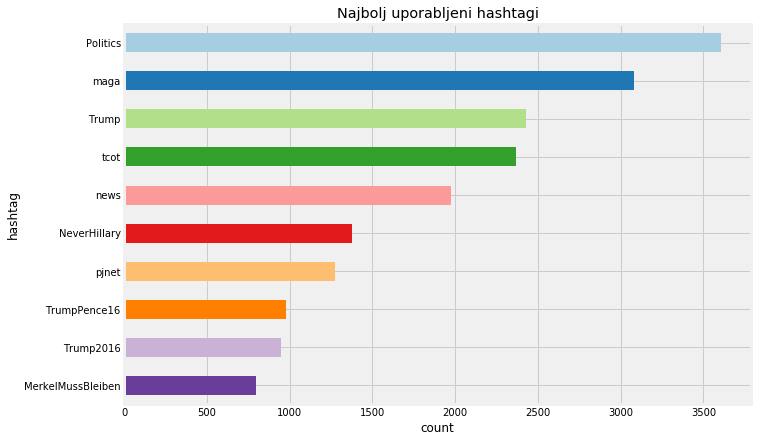

In [5]:
hashtags = np.array(tweets_data['hashtags'].apply(ast.literal_eval))
top10_hashtags = pd.Series(np.hstack(hashtags)).value_counts().nlargest(10)
top10_hashtags.T.plot(kind='barh', figsize=(10, 7), color=plt.cm.Paired(np.arange(len(top10_hashtags))))
plt.title('Najbolj uporabljeni hashtagi')
plt.xlabel('count')
plt.ylabel('hashtag')
plt.gca().invert_yaxis()

Osnovni graf hashtagov glede na število pojavitev prikazuje porazdelitev desetih najpogostejših hashtagov. Najzanimivejša sta #pjnet in #MerkelMussBleiben. Prvi je okrajšava za Patriot Journalist Network, družba ki je med volitvami na Twitterju vzdrževala bota, ki naj bi vsak dan objavil tisoč tweetov. Slednja pa namiguje, da so troli komentirali tudi zadeve izven Ameriške sfere.

## Omenjeni uporabniki

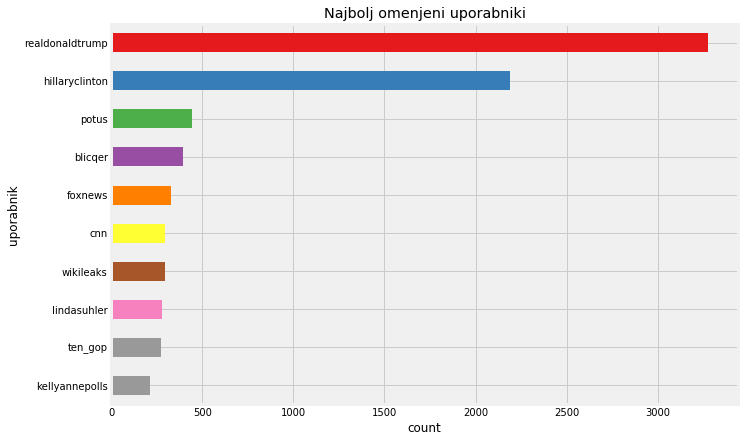

In [6]:
mentions = np.array(tweets_data['mentions'].apply(ast.literal_eval))
top10_mentions = pd.Series(np.hstack(mentions)).value_counts().nlargest(10)
top10_mentions.plot(kind='barh', figsize=(10, 7), color=plt.cm.Set1(np.arange(len(top10_mentions))))
plt.title('Najbolj omenjeni uporabniki')
plt.xlabel('count')
plt.ylabel('uporabnik')
plt.gca().invert_yaxis()

Vidimo, da je najbolj omenjen uporabnik v tweetih bil *@realdonaldtrump*, med najbolj omenjenimi pa se pojavi celo *@ten_gop*, ki je bil v našem datasetu označen kot ruski troll.

## Najbolj aktivni uporabniki

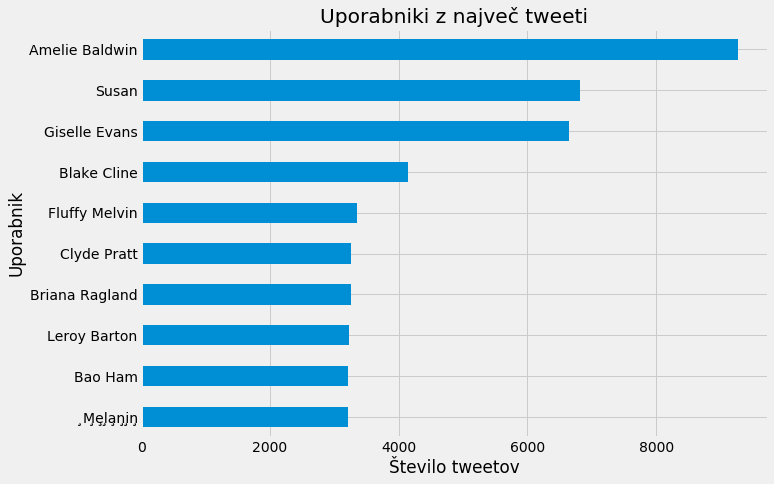

In [70]:
merged = pd.merge(tweets_data, users_data, left_on='user_id', right_on='id')
merged['name'].value_counts().nlargest(10).plot.barh(figsize=(10,7))
plt.title('Uporabniki z največ tweeti')
plt.xlabel('Število tweetov')
plt.ylabel('Uporabnik')
plt.gca().invert_yaxis()

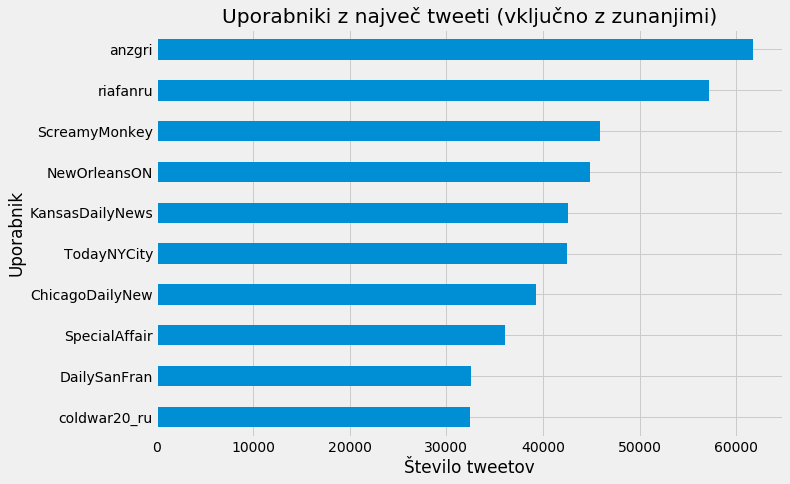

In [79]:
users_data.set_index('screen_name')['statuses_count'].nlargest(10).plot.barh(figsize=(10,7))
plt.title('Uporabniki z največ tweeti (vključno z zunanjimi)')
plt.xlabel('Število tweetov')
plt.ylabel('Uporabnik')
plt.gca().invert_yaxis()

Zgornji graf prikazuje uporabnike, ki so imeli največje število tweetov, vključno s tistimi, ki se ne nahajajo v našem datasetu. Vidimo, da so imeli največ tweetov trolli, ki so se pretvarjali, da so novičarski portali.

## Povezanost uporabnikov

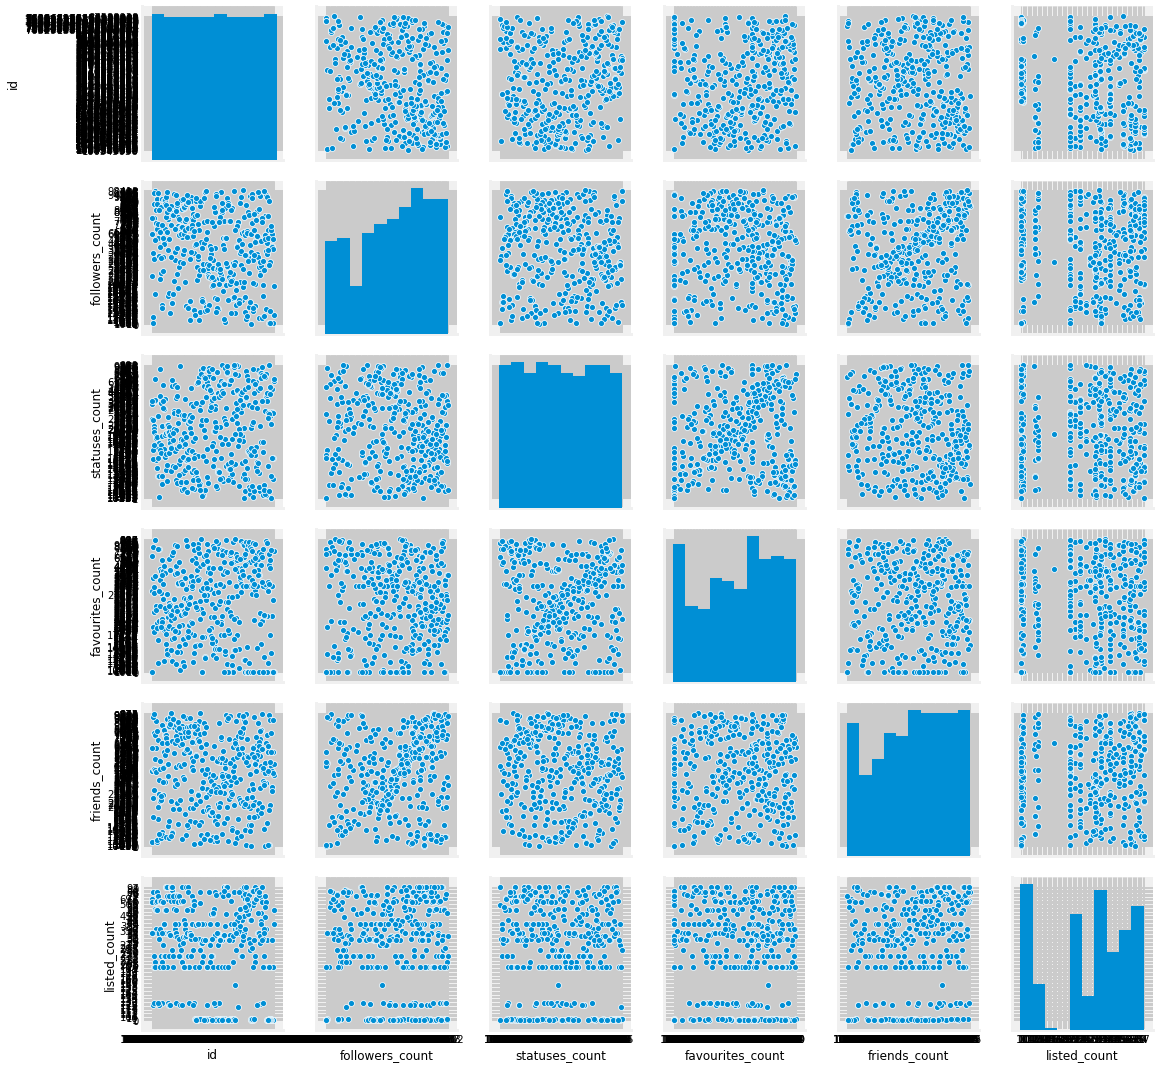

In [4]:
users = pd.read_csv("podatki/users.csv", sep=",", dtype=object)
users = users[pd.notnull(users['id'])]
sb.pairplot(users)

### Korelacija podatkov pri uporabnikih.

Zgornji grafi so grafi ki prikazujejo povezavo med vsemi atributi med sabo. Pri večini atributov se takojšnje povezave ne opazi, le pri atributih *friends_count* - *followers_count*  in   *favourtites_count* - *statuses_count* se opazi zgostitev točk po diagonali. Na koncu teh korelacij nisem porabil nikjer.

In [8]:
tweets_data = pd.read_csv("podatki/tweets.csv", dtype=object)
tweets_data = tweets_data[pd.notnull(tweets_data['user_id'])]

retweeted_status_ids = tweets_data['retweeted_status_id'].loc[pd.notnull(tweets_data['retweeted_status_id'])]
retweeted_df = tweets_data[pd.notnull(tweets_data['retweeted_status_id'])]

retweets = tweets_data['tweet_id'].loc[tweets_data['tweet_id'].isin(retweeted_status_ids)]
retweets_df = tweets_data[tweets_data['tweet_id'].isin(retweeted_status_ids)]

In [77]:
retweeted_tweets_from_dataset = tweets_data[tweets_data['tweet_id'].isin(retweeted_status_ids)]['tweet_id']

connections = tweets_data[tweets_data['retweeted_status_id'].isin(retweeted_tweets_from_dataset)]
connections = connections[['tweet_id','retweeted_status_id' ]]

### Razlaga kode

Zgonja koda prebere vse tweete iz .csv datoteke, nato pa odstrani vse tweete, pri katerih nam user_id ni znan (NaN). Nato ustvarim seznam vseh tweet_id-jev, ki so bili retweetani v tem datasetu.

Potem ustvarim nov Dataframe, ki vsebuje samo tiste tweete, kateri so retweetali tweete iz tega dataseta. Tako dobimo DataFrame tweetov, ki so bili retweetani med boti.

Ustvaril sem še *connections* Dataframe. Ta vsebuje samo dva atributa: *tweet_id* in *retweeted_status_id*, s tem si poenostavim gradnjo spodnjih grafov.

In [81]:
G = nx.DiGraph()
for i in connections.values:
    G.add_edge(i[0], i[1])
most_retweeted =  sorted(G.degree, key=lambda x: x[1], reverse=True)[:1][0][0]
print("Najbolj retweetan tweet med boti je: \n")
print(tweets_data[['user_key', 'text']].loc[tweets_data['tweet_id'] == most_retweeted])

Najbolj retweetan tweet med boti je: 

          user_key               text
37404  notritahart  #HowToLoseYourJob


S pomočjo networkx knjižnice sem ustvaril usmerjen graf. Povezave na grafu delujejo tako, da je povezava med dvema tweetoma usmerjena v smeri originalnega tweeta. Torej retweet kaže proti originalnem tweetu.

Naredila se je še kratka analiza, kater tweet ima največjo stopnjo v grafu. Izkazalo se je da je to tweet uporabnika **notritahart** z vsebino: "#HowToLoseYourJob"

<function matplotlib.pyplot.show(*args, **kw)>

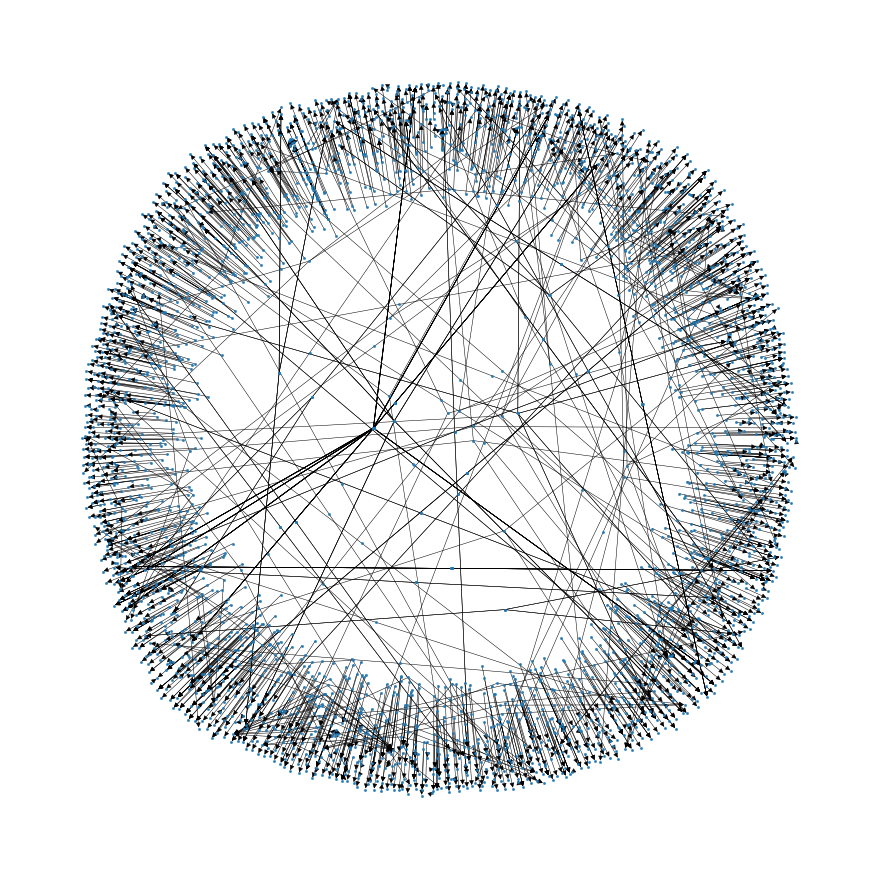

In [14]:
plt.figure(3, figsize=(12, 12))
nx.draw(G, pos=nx.spring_layout(G), with_labels=False, node_size=5, width=0.5)
plt.show

Ko izrišemo graf se opazi da veliko tweetov bilo retweetanih samo enkrat. Taki tweeti nam ne povejo veliko in na grafu delajo navlako. Zato sem vsa vozlišča (tweete), ki imajo stopnjo manj kot dve zbrisal. Po tem ostane veliko novih vozlišč z stopnjo 0, tako da tista vozlišče zbrišem posebaj


In [ ]:
node_list = G.node()
remove = []
for i in node_list:
    if G.degree(i) < 2:
        remove.append(i)
len(remove)
G.remove_nodes_from(remove) 

node_list = G.node()
remove = []
for i in node_list:
    if G.degree(i) == 0:
        remove.append(i)
len(remove)
G.remove_nodes_from(remove) 

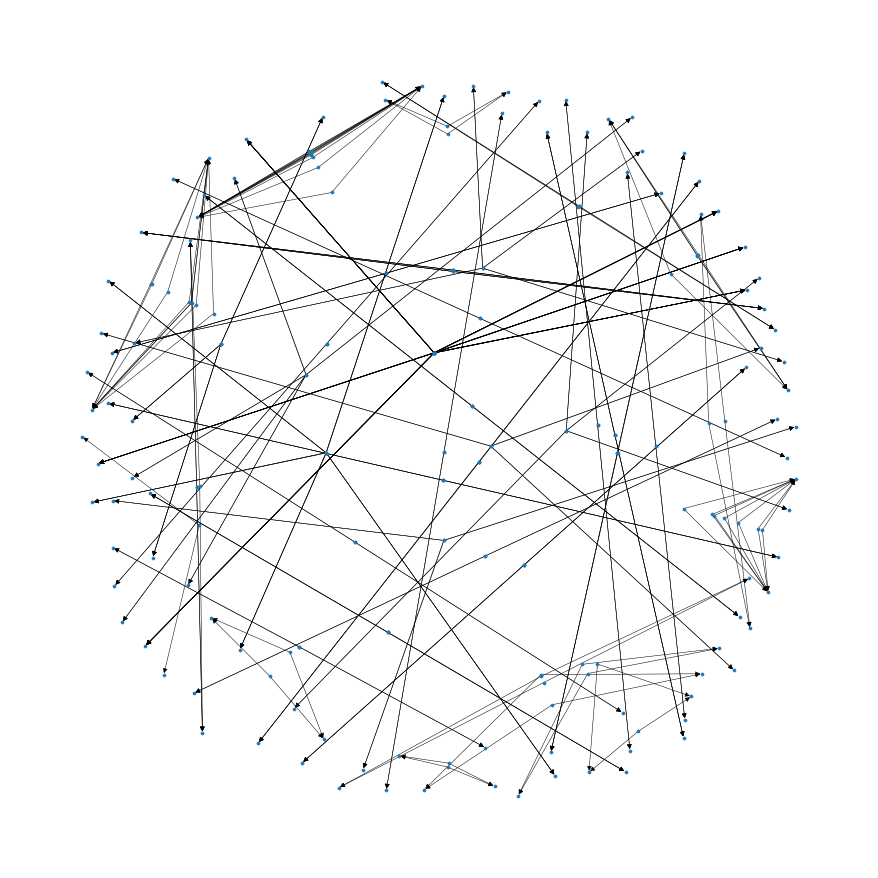

In [47]:

plt.figure(3, figsize=(12, 12))
nx.draw(G, pos=nx.spring_layout(G, k=0.05), with_labels=False, node_size=10, width=0.5)
plt.show()

Ko je graf očiščen, se opazi zanimiva mreža. Večina vozlišč z višjimi stopnjami so tista, ki so retweetali. Je pa nekaj originalnih tweetov, ki so bili velikokrat retweetani 

In [48]:
userGraph = nx.DiGraph()
for i in connections.values:
    r_usr = tweets_data['user_id'].loc[tweets_data['tweet_id'] == i[0]].iloc[0]
    o_usr = tweets_data['user_id'].loc[tweets_data['tweet_id'] == i[1]].iloc[0]
    userGraph.add_edge(r_usr, o_usr)

### Boti, katere so ostali boti največkrat retweetali

Ustvaril sem nov graf, ta ima tokrat za vrednost vozlišča id uporabnika, ki je tweetal določen tweet. Za povezave se je še vedno uporabil Dataframe connections. Iz tweet_id-ja in retweeted_status_id-ja sem pridobil user_id uporabnika ki je tweetal določen tweet.

Prikaz naslednjega grafa je zelo zanimiv

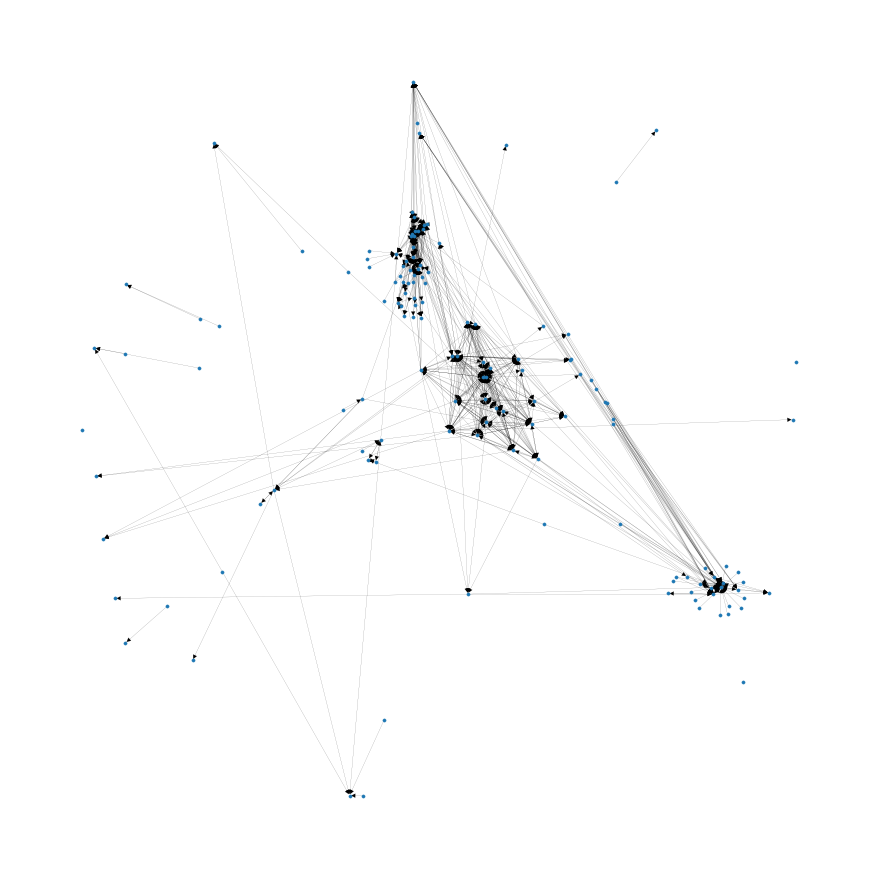

In [49]:
plt.figure(3, figsize=(12, 12))
nx.draw(userGraph, pos=nx.spring_layout(userGraph), with_labels=False, node_size=10, width=0.1)
plt.show()

Zgornji graf nam prikaže da obstajajo boti, katere so ostali boti v večjih številih retweetali. Tista vozlišča, katera so obdana s puščicami pomeni da je drugih uporabnikov retweetalo tweete tega uporabnika. 

In [61]:
maxUser = None
maxDeg = -math.inf 
for k, v in userGraph.degree():
    if maxUser == None:
        maxUser = k
        maxDeg = v
        continue
    if v > maxDeg:
        maxUser = k
        maxDeg = v
print("{}: {}".format(maxUser, maxDeg))
print(tweets_data[tweets_data['user_id'] == maxUser]['user_key'].sample(1).values[0])

4224729994: 51
ten_gop


In [62]:
top_ten=sorted(userGraph.degree, key=lambda x: x[1], reverse=True)[:10]
for k, v in top_ten:
    print(tweets_data[tweets_data['user_id'] == k]['user_key'].sample(1).values[0])

ten_gop
giselleevns
michellearry
garrettsimpson_
_nickluna_
heyits_toby
melvinsroberts
leroylovesusa
jeffreykahunas
emileewaren


Po analizi vozlišč, sem izpisal uporabniška imena tistih botov, ki imajo največje stopnje. Največjo stopnjo je imel uporabnik
ten_gop. V naši bazi uporabnikov, zgleda kot nič posebnega, vendar z malo brskanja po spletu, se razvidi da je to eden od bolj vplivnih twitter botov. Uporabniško ime bota se je celo prikazal na eni izmed Muellerjevih [obtožnic](https://www.documentcloud.org/documents/4380502-Indictment.html#document/p15/a404968)

### Analiza mesečnih hashtagov

In [3]:
import os
os.chdir(".\DictReader")
import Read
data = Read.DataHoard()

Iz porazdeliteve nastanka člankov in tweetov glede na čas sem zaseledil, da pogosto naraščajo glede na svetovna dogajanja. Zato sem pregledal najpogostejše hashtage za vsak mesec in tako poskušal najti kake zanimive povezave.

Number of unique hashtags: 85


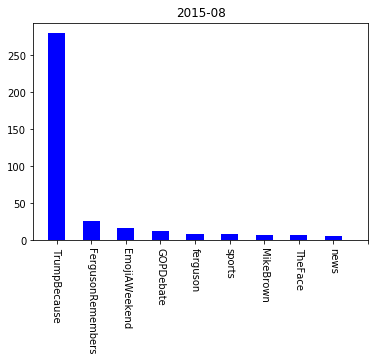

~~~~~~~~~~~~~~~~~~


In [4]:
Read.quick_dated_tweet(data.dated_tweets,"2015-08")

Ta graf je poseben zaradi #TrumpBecause, ki se pojavi samo v mesecu Avgustu in je prvi primer čiste propagande za takratnega Trumpa. Tudi ne gre izključno za "nadzorovnje škode" pri incidentu z zmerjanjem novinarke Meagan Kelly, saj so se ti tweeti začeli 3 dni pred škandalom.

Number of unique hashtags: 341


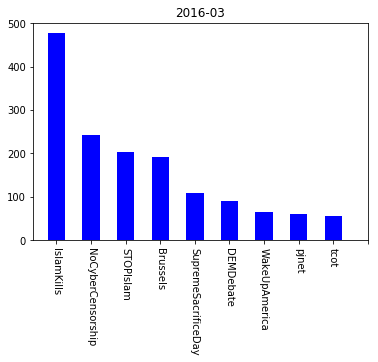

~~~~~~~~~~~~~~~~~~


In [5]:
Read.quick_dated_tweet(data.dated_tweets,"2016-03")

Ta mesec je izstopal predvsem zaradi islamofobičnih hashtagov, ki so se sicer že prej pojavljali, a nikoli v takem številu. Glavni vzrok za to je bil terroristični napad v Bruslju.

Number of unique hashtags: 602


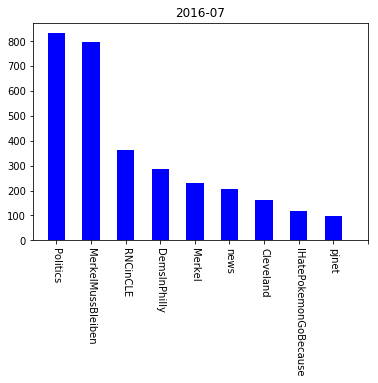

~~~~~~~~~~~~~~~~~~


In [6]:
Read.quick_dated_tweet(data.dated_tweets,"2016-07")

Ta mesec je zelo zanimiv, saj se drugi največji hashtag prevede v "Merkel mora oditi", kar je posledica povečane frekvence zločinskih dejavnosti priseljencev v Nemčiji in poosodobitve zastarelih zakonov o posilstvu.

Iz tega grafa lahko tudi sklepamo, da obstaja možnost delovanja ruskih trolov tudi v drugih državah.

Number of unique hashtags: 2556


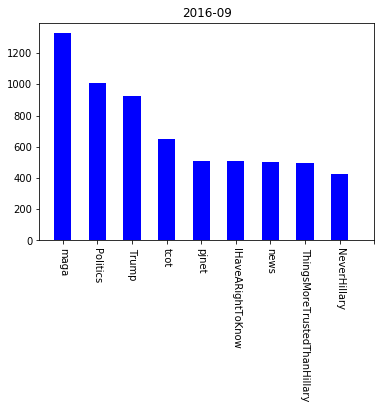

~~~~~~~~~~~~~~~~~~


In [7]:
Read.quick_dated_tweet(data.dated_tweets,"2016-09")

Ta mesec izstopa predvsem zaradi velika števila unikatnih hashtagov in števila pojavljanja že uveljavljenih. Ta trend se ohranja tekom volitvene kampanje, nakar frekvenca in število unikatnih hashtagov pojenjata.

### Gručenje po podobosti linkov in hashtagov
Izvedel sem preprosto gručenje po uporabnikih glede na njihovo uporabo hashtagov in linkov. To sem izvedel tako da ima vsak uporabnik množico unikatnih podatkov, ki so jih uporabili v svojih tweetih.

Uporabnike sem nato spravil v mrežo, kjer so povezave med njimi pogojene z:

Teža = (Presek množic/Unija množic)

Te vrednosti za linke hashtage sem nato preprosto seštel in razdelil njihove vrednosti na tri razrede:

Zelena - Teža < 0.1

Modra - Teža < 0.5 

Rdeča - 0.5 < Teža 


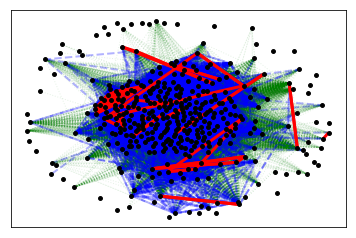

In [8]:
Read.the_graph(data,label=False)
os.chdir("..")

Graf je zelo nepregeden, ampak iz njega lahko vidimo preko rdečih povezav določene skupine uporabnikov, ki imajo nekaj skupnega.

Za boljšo preglednost na grafu izrišemo le vozlišča z rdečimi povezavami.

<img src="images/filtered_graph.png">

Iz tega grafa lahko vidimo, da obstaja glavna gruča devetih uporabnikov, poleg manjših skupin. Imena uporabnikov v skupinah sem ročno shranil v ločeno datoteko. Uporabniki v največji skupini so:

KadirovRussia

MargoSavazh

LavrovMuesli

coldwar20_ru

abigailssilk

Shocko_10

DonnieLMiller

bydrbre_

LGBTuni


### Korelacija med štirimi različnimi uporabniki
Med uporabniki je opaziti, da uporabljajo različne hashtage v svojih tweetih oz. imajo različne ciljne skupine. Odločil sem se za nekaj najaktivnejših uporabnikov.


To so: "ameliebaldwin", "giselleevns", "baobaeham", "ten_gop". Slednjega sem v to analizo vnesel le, ker smo pri delu ugotovili, da je to najvplivnejši uporabnik v naši množici podatkov.

Spodaj so samo slike nekaterih grafov, celotno analizo o teh štirih uporabnikih, s kodo pa je na voljo <a href="korelacijaMedTipiUporabnikov.ipynb">na tej povezavi</a>.

<img src="Images/amelie_hashtags.png"/><br/>
Kot vidimo v tem grafu gre tukaj za klasčnega pro-trump bota. Po večini so uporabljeni hashtagi namenjeni propagandi, ki spodbuja k voljenju Donalda Trumpa <hr/>
<img src="Images/gisell_hashtags.png"/><br/>
Pri tem uporabniku je videti, da ta uporabnik uporablja zelo drugačne hashtage od prejšnjega. Sodeč po najbolj uporabljenih lahko smatramo, da gre za povprečnega uporabnika na tweeterju. Če pa se spustimo v podrobnosti, pa lahko tudi opazimo, da v nekaterih tweetih izraža nasprotovanje volitvam, primer tega je: <img src="Images/tweet.png"/><hr/>
<img src="Images/baobae_hashtags.png"/><br/>
V zgornjem grafu vidimo, da gre tokrat za uporabnika, ki se zelo osredotoča na glasbo. Tudi pri njemu lahko najdemo podobne tweete, kot pri uporabniko "giselleevns", le da je ciljna skupina pri slednjem druga.<hr/>
<img src="Images/ten_hashtags.png"/><br/>
Zadnji uporabnik pa je uporabnik, ki je v naši množici najvplivnejši uporabnik. Pri njem prav tako vidimo pro-trump in anti-hillary, pod največkrat uporabljenimi hashtagi, med njimi pa se še pojavljajo hashtagi na temo "debate", kar bi pojasnilo njegovo vplivnost, ta uporabnik je namreč navezal stik z največ različnimi uporabniki.<hr/>
<br/>
<img src="Images/users_activity.png"/><br/>
Na koncu sem še izrisal graf aktivnosti zgornjih štirih uporabnikov, ugotovimo lahko da so vsi uporabniki opazno pričeli tweetati v približno enakem obdobju. Obdobje je bilo jeseni 2016, kar je čas volitev za predsednika v ZDA. <hr/>
